# Price Change in Cryptocurrencies for Trading Sessions

Based on code and article by @Data_Always <br>
Original code: https://github.com/dataalways/region-driven-price-changes <br>
Article: https://codingalways.substack.com/p/region-driven-price-changes?s=r <br>

Intended as a 

In [199]:
import numpy as np
import pandas as pd
from coinmetrics.api_client import CoinMetricsClient
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

warnings.filterwarnings('ignore')

client = CoinMetricsClient()

In [200]:
def set_plt_defaults():
    plt.rcParams['figure.figsize'] = (16,10) # default figure size
    
    # position of chart in figure
    plt.rcParams['figure.subplot.left'] = 0.1
    plt.rcParams['figure.subplot.top'] = 0.92
    plt.rcParams['figure.subplot.right'] = 0.9
    
    # outputs
    fig_out = plt.figure()
    ax_out = plt.subplot2grid((1,1),(0,0))
    
    # no tick dashes at the left-boundary of the grid
    ax_out.yaxis.set_ticks_position('none')
    
    # gridline style
    plt.grid(color=[0.25]*3, 
             linestyle='-', 
             linewidth=0.75, 
             alpha=0.25, 
             zorder=0
            )
    
    # only plot horizontal gridlines
    ax_out.xaxis.grid()
    
    # plot x-axis zero line
    ax_out.axhline(linewidth=1, color='black')
    
    plt.box(False)
    
    return fig_out, ax_out;

The data used was retrieved from [CryptoDataDownload](https://www.cryptodatadownload.com/) and corresponds to data from the exchange Bitfinex. The original [jupyter notebook](https://github.com/dataalways/region-driven-price-changes/blob/main/walkthrough.ipynb) by @Data_Always used data from Gemini. 

In [201]:
# read data for btc
btc_data = pd.read_csv(r'/Users/danielroyo2227/kodama/data_analysis/data/cryptodatadownload/Bitfinex_BTCUSD_1h.csv', skiprows=1)

# transform to dataframe
btc_df = pd.DataFrame(btc_data)

# rename columns
btc_df.columns = ['timestamp', 
                  'date',
                  'symbol',
                  'open',
                  'high',
                  'low',
                  'close',
                  'volumeUSD',
                  'volumeBTC'
                 ]

# set date as main index and sort by date
btc_df = btc_df.sort_values(by="date")
btc_df = btc_df.set_index(pd.DatetimeIndex(btc_df['date']))

In [202]:
btc_df.head()

,timestamp,date,symbol,open,high,low,close,volumeUSD,volumeBTC
date,,,,,,,,,
2018-05-15 06:00:00,1526364000,2018-05-15 06:00:00,BTC/USD,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35
2018-05-15 07:00:00,1526367600,2018-05-15 07:00:00,BTC/USD,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97
2018-05-15 08:00:00,1526371200,2018-05-15 08:00:00,BTC/USD,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31
2018-05-15 09:00:00,1526374800,2018-05-15 09:00:00,BTC/USD,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55
2018-05-15 10:00:00,1526378400,2018-05-15 10:00:00,BTC/USD,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08


In this analysis we want to see price performance in the different trading sessions, namely Asia, Europe and US.

We define these trading sessions in GMT as:

Asia: 9pm to 5am<br>
Europe: 5am to 1pm<br>
US: 1pm to 9pm<br>

In [203]:
# create new columns for day and hour 
btc_df['hour'] = [pd.to_datetime(val).time().hour for val in btc_df['date']]
btc_df['date'] = [pd.to_datetime(val).date() for val in btc_df['date']]

In [204]:
btc_df.head()

,timestamp,date,symbol,open,high,low,close,volumeUSD,volumeBTC,hour
date,,,,,,,,,,
2018-05-15 06:00:00,1526364000,2018-05-15,BTC/USD,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35,6
2018-05-15 07:00:00,1526367600,2018-05-15,BTC/USD,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97,7
2018-05-15 08:00:00,1526371200,2018-05-15,BTC/USD,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31,8
2018-05-15 09:00:00,1526374800,2018-05-15,BTC/USD,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55,9
2018-05-15 10:00:00,1526378400,2018-05-15,BTC/USD,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08,10


In [205]:
# dsitribute data based on trading session
btc_df['asia'] = btc_df['hour'].apply(lambda x: 1 if x < 7 or x >= 23 else 0)
btc_df['europe'] = btc_df['hour'].apply(lambda x: 1 if x < 15 and x >= 7 else 0)
btc_df['us'] = btc_df['hour'].apply(lambda x: 1 if x < 23 and x >= 15 else 0)

btc_df.head(25)

,timestamp,date,symbol,open,high,low,close,volumeUSD,volumeBTC,hour,asia,europe,us
date,,,,,,,,,,,,,
2018-05-15 06:00:00,1526364000,2018-05-15,BTC/USD,8723.8,8793.00,8714.9,8739.0,8988053.53,1026.35,6,1,0,0
2018-05-15 07:00:00,1526367600,2018-05-15,BTC/USD,8739.0,8754.80,8719.3,8743.0,2288904.12,261.97,7,0,1,0
2018-05-15 08:00:00,1526371200,2018-05-15,BTC/USD,8743.0,8743.10,8653.2,8723.7,8891773.14,1023.31,8,0,1,0
2018-05-15 09:00:00,1526374800,2018-05-15,BTC/USD,8723.7,8737.80,8701.2,8708.1,2054868.28,235.55,9,0,1,0
2018-05-15 10:00:00,1526378400,2018-05-15,BTC/USD,8708.1,8855.70,8695.8,8784.4,17309722.58,1969.08,10,0,1,0
2018-05-15 11:00:00,1526382000,2018-05-15,BTC/USD,8784.4,8804.90,8734.8,8755.2,5755257.93,656.47,11,0,1,0
2018-05-15 12:00:00,1526385600,2018-05-15,BTC/USD,8755.2,8789.10,8743.0,8762.0,4406994.79,502.92,12,0,1,0
2018-05-15 13:00:00,1526389200,2018-05-15,BTC/USD,8762.0,8798.10,8633.0,8742.6,16375559.14,1877.56,13,0,1,0
2018-05-15 14:00:00,1526392800,2018-05-15,BTC/USD,8742.6,8742.70,8480.2,8512.0,30884779.63,3610.57,14,0,1,0


In [206]:
# calculate difference in price with respect to the close for every trading session
btc_df['asia-change'] = btc_df['close'].diff() * btc_df['asia']
btc_df['europe-change'] = btc_df['close'].diff() * btc_df['europe']
btc_df['us-change'] = btc_df['close'].diff() * btc_df['us']

btc_df.head(20)

,timestamp,date,symbol,open,high,low,close,volumeUSD,volumeBTC,hour,asia,europe,us,asia-change,europe-change,us-change
date,,,,,,,,,,,,,,,,
2018-05-15 06:00:00,1526364000,2018-05-15,BTC/USD,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35,6,1,0,0,NaN,NaN,NaN
2018-05-15 07:00:00,1526367600,2018-05-15,BTC/USD,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97,7,0,1,0,0.0,4.0,0.0
2018-05-15 08:00:00,1526371200,2018-05-15,BTC/USD,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31,8,0,1,0,-0.0,-19.3,-0.0
2018-05-15 09:00:00,1526374800,2018-05-15,BTC/USD,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55,9,0,1,0,-0.0,-15.6,-0.0
2018-05-15 10:00:00,1526378400,2018-05-15,BTC/USD,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08,10,0,1,0,0.0,76.3,0.0
2018-05-15 11:00:00,1526382000,2018-05-15,BTC/USD,8784.4,8804.9,8734.8,8755.2,5755257.93,656.47,11,0,1,0,-0.0,-29.2,-0.0
2018-05-15 12:00:00,1526385600,2018-05-15,BTC/USD,8755.2,8789.1,8743.0,8762.0,4406994.79,502.92,12,0,1,0,0.0,6.8,0.0
2018-05-15 13:00:00,1526389200,2018-05-15,BTC/USD,8762.0,8798.1,8633.0,8742.6,16375559.14,1877.56,13,0,1,0,-0.0,-19.4,-0.0
2018-05-15 14:00:00,1526392800,2018-05-15,BTC/USD,8742.6,8742.7,8480.2,8512.0,30884779.63,3610.57,14,0,1,0,-0.0,-230.6,-0.0


In [207]:
# restructure dataframe so it provides daily data instead of hourly
# and compute sum of difference in price respect close for each session
resample_dict = {
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last',
    'volumeUSD':'sum',
    'volumeBTC':'sum',
    'asia-change':'sum',
    'europe-change':'sum',
    'us-change':'sum',
    'date':'first'
}

# resample data
btc_df = btc_df.resample("1D").agg(resample_dict)

# convert day date from string to datetime object
btc_df['date'] = pd.to_datetime(btc_df['date'])

In [208]:
btc_df.head(10)

,open,high,low,close,volumeUSD,volumeBTC,asia-change,europe-change,us-change,date
date,,,,,,,,,,
2018-05-15,8723.80,8855.70,8415.0,8467.50,1.866897e+08,21717.66,7.60,-227.0,-52.10,2018-05-15
2018-05-16,8467.50,8492.70,8100.0,8336.10,2.652541e+08,32084.65,-185.60,-18.0,72.20,2018-05-16
2018-05-17,8336.10,8482.20,7982.5,8054.30,2.033311e+08,24704.09,-13.90,-26.0,-241.90,2018-05-17
2018-05-18,8054.30,8277.20,7925.0,8238.90,1.842360e+08,22748.14,-65.40,110.9,139.10,2018-05-18
2018-05-19,8238.90,8430.00,8140.2,8231.00,1.095607e+08,13253.74,-6.70,86.0,-87.20,2018-05-19
2018-05-20,8231.00,8597.90,8171.5,8523.60,1.272329e+08,15137.61,48.30,94.1,150.20,2018-05-20
2018-05-21,8523.60,8644.00,8309.1,8398.80,1.375879e+08,16283.11,35.20,-145.2,-14.80,2018-05-21
2018-05-22,8398.80,8408.28,7943.3,7977.85,1.651442e+08,20195.40,-71.75,-93.0,-256.20,2018-05-22
2018-05-23,7977.85,8020.00,7403.0,7494.80,3.060821e+08,39746.95,-84.35,-64.8,-333.90,2018-05-23


In [209]:
# create a temporary copy of dataframe from a start date (April 2020 in this case)
start_date = '2020-10-01'
tmp_df = btc_df[btc_df.date > start_date]

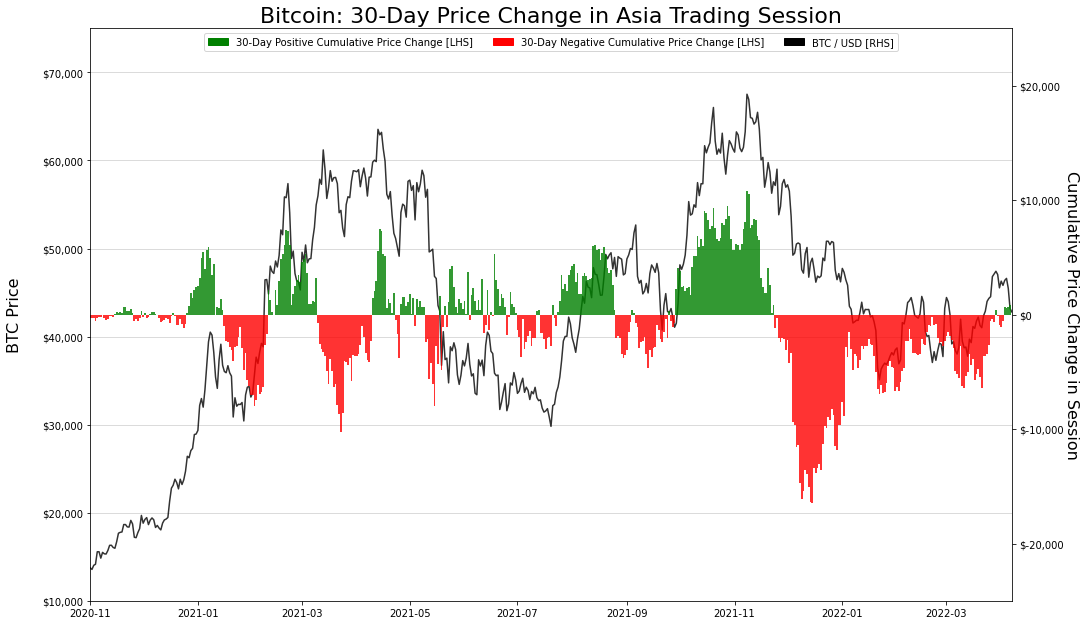

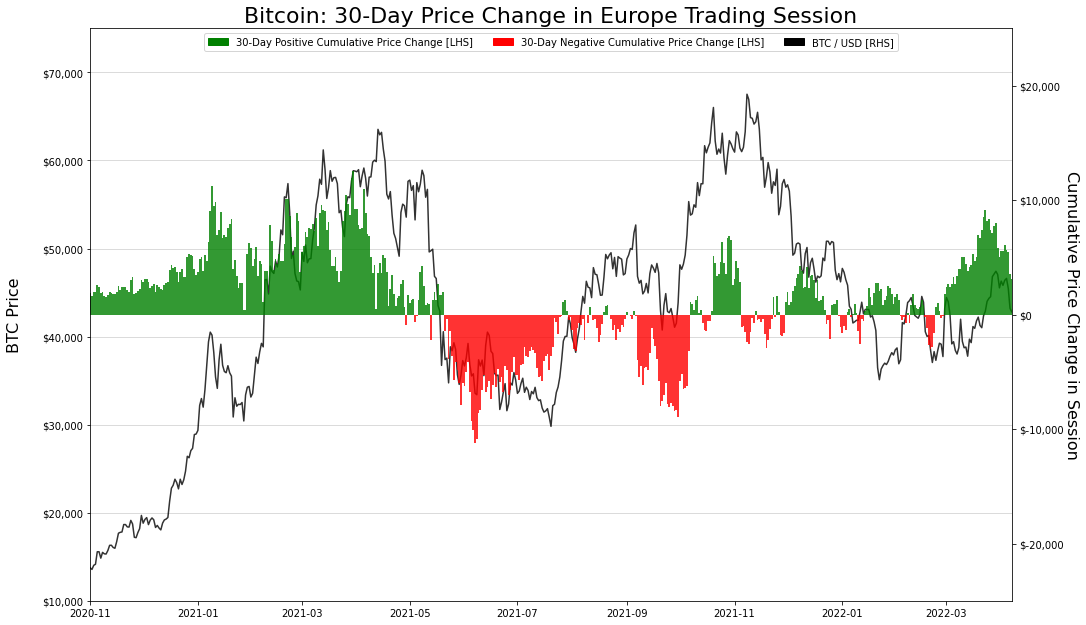

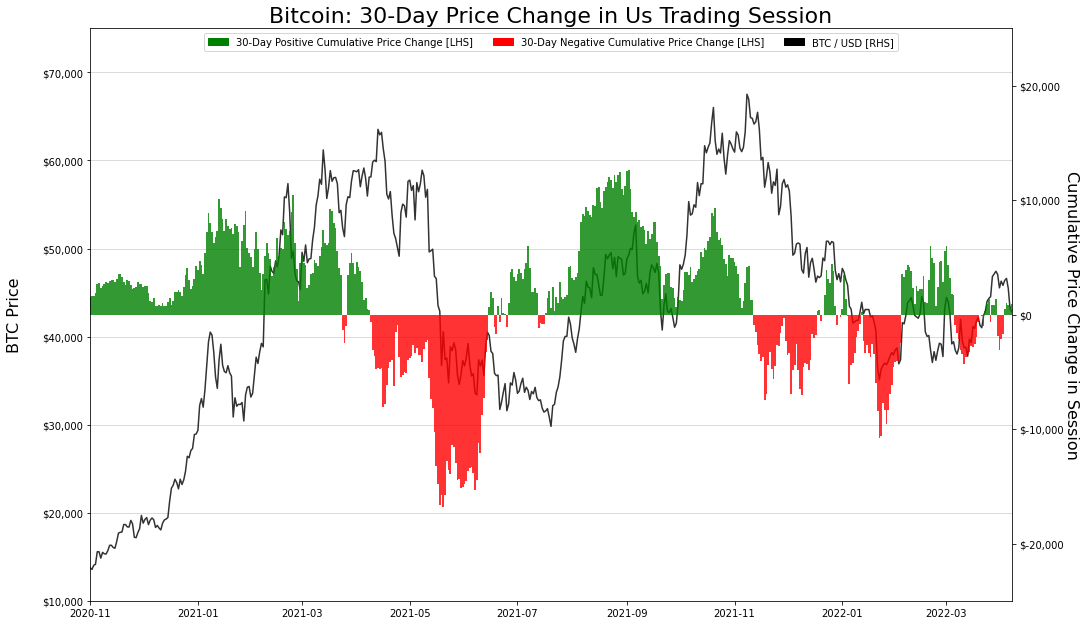

In [210]:
session = ['asia', 'europe', 'us']

for s in session:
    # create a figure with our default parameters
    fig, ax1 = set_plt_defaults()

    # dynamic title dependant on window size
    plt.title(f'Bitcoin: {ws}-Day Price Change in {s.capitalize()} Trading Session', size=22)
    
    ax1.plot(tmp_df['date'], 
             tmp_df['close'], 
             color='k', 
             alpha=0.8)
    
    ax1.set_ylabel('BTC Price', fontsize=16, labelpad=20)

    ax1.set_ylim([10000, 75000])
    ax1.set_yticklabels(['${:,.0f}'.format(x) for x in ax1.get_yticks()])
    
    # create copy of x-axis so we can plot another data segment
    ax2 = ax1.twinx()

    # custom labels
    green_patch = mpatches.Patch(color='g', label=f'{ws}-Day Positive Cumulative Price Change [LHS]')
    red_patch = mpatches.Patch(color='r', label=f'{ws}-Day Negative Cumulative Price Change [LHS]')
    black_patch = mpatches.Patch(color='k', label='BTC / USD [RHS]')

    # add legend
    ax1.legend(handles=[green_patch, red_patch, black_patch], loc='upper center', ncol=3)


    # bar plot, red for negative prices and green for positive
    ax2.bar(tmp_df['date'], 
            tmp_df[f'{s}-change'].rolling(ws).sum(), 
            width=1.0, 
            alpha=0.8,
            color=['r' if (x < 0) else 'g' for x in tmp_df[f'{s}-change'].rolling(ws).sum()])

    #set y label 
    ax2.set_ylabel('Cumulative Price Change in Session', rotation=270, fontsize=16, labelpad=16)
    
    # set axis boundary limits
    ax2.set_xlim(tmp_df['date'][ws], tmp_df['date'][-1])
    ax2.set_ylim([-25000, 25000])

    # set tick labels
    ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])


    #save figure
    plt.savefig(f'./img/btc_price-change-{s}.png', transparent=False, facecolor='white')

    plt.show()

## Ethereum 
Same for et hirium

In [211]:
# read data for eth
eth_data = pd.read_csv(r'/Users/danielroyo2227/kodama/data_analysis/data/cryptodatadownload/Bitfinex_ETHUSD_1h.csv', skiprows=1)

# transform to dataframe
eth_df = pd.DataFrame(eth_data)

# rename columns
eth_df.columns = ['timestamp', 
                  'date',
                  'symbol',
                  'open',
                  'high',
                  'low',
                  'close',
                  'volumeUSD',
                  'volumeeth'
                 ]

# set date as main index and sort by date
eth_df = eth_df.sort_values(by="date")
eth_df = eth_df.set_index(pd.DatetimeIndex(eth_df['date']))

# create new columns for day and hour 
eth_df['hour'] = [pd.to_datetime(val).time().hour for val in eth_df['date']]
eth_df['date'] = [pd.to_datetime(val).date() for val in eth_df['date']]

# xxxxx data based on trading session
eth_df['asia'] = eth_df['hour'].apply(lambda x: 1 if x < 7 or x >= 23 else 0)
eth_df['europe'] = eth_df['hour'].apply(lambda x: 1 if x < 15 and x >= 7 else 0)
eth_df['us'] = eth_df['hour'].apply(lambda x: 1 if x < 23 and x >= 15 else 0)

# calculate difference in price with respect to the close for every trading session
eth_df['asia-change'] = eth_df['close'].diff() * eth_df['asia']
eth_df['europe-change'] = eth_df['close'].diff() * eth_df['europe']
eth_df['us-change'] = eth_df['close'].diff() * eth_df['us']

# restructure dataframe so it provides daily data instead of hourly
# and compute sum of difference in price respect close for each session
resample_dict = {
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last',
    'volumeUSD':'sum',
    'volumeeth':'sum',
    'asia-change':'sum',
    'europe-change':'sum',
    'us-change':'sum',
    'date':'first'
}

# resample data
eth_df = eth_df.resample("1D").agg(resample_dict)

# convert day date from string to datetime object
eth_df['date'] = pd.to_datetime(eth_df['date'])

# create a temporary copy of dataframe from a start date (April 2020 in this case)
start_date = '2020-10-01'
tmp_df = eth_df[eth_df.date > start_date]


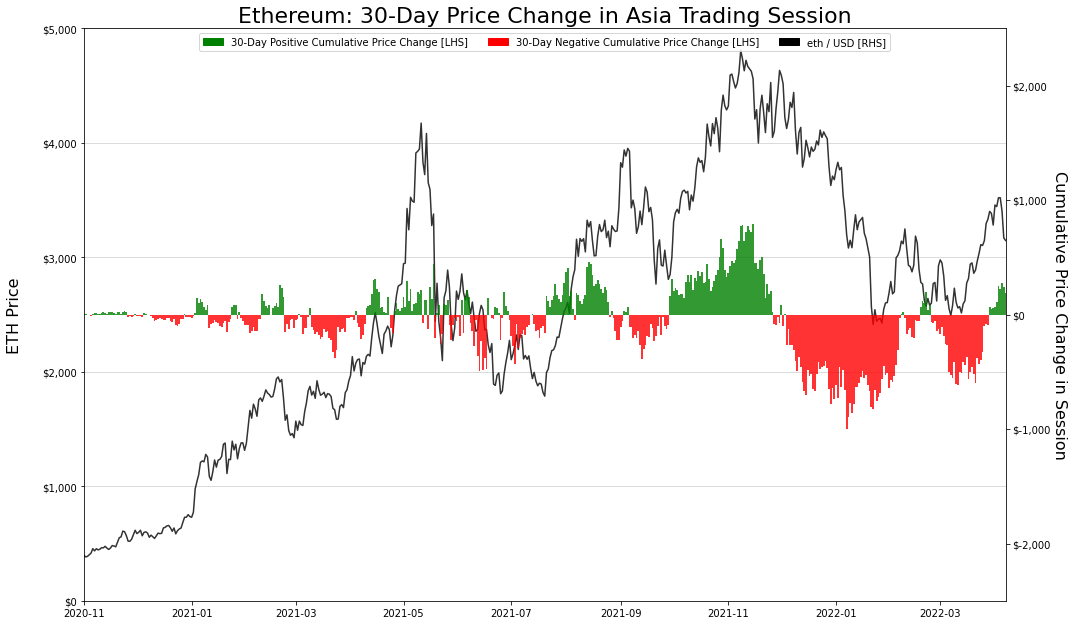

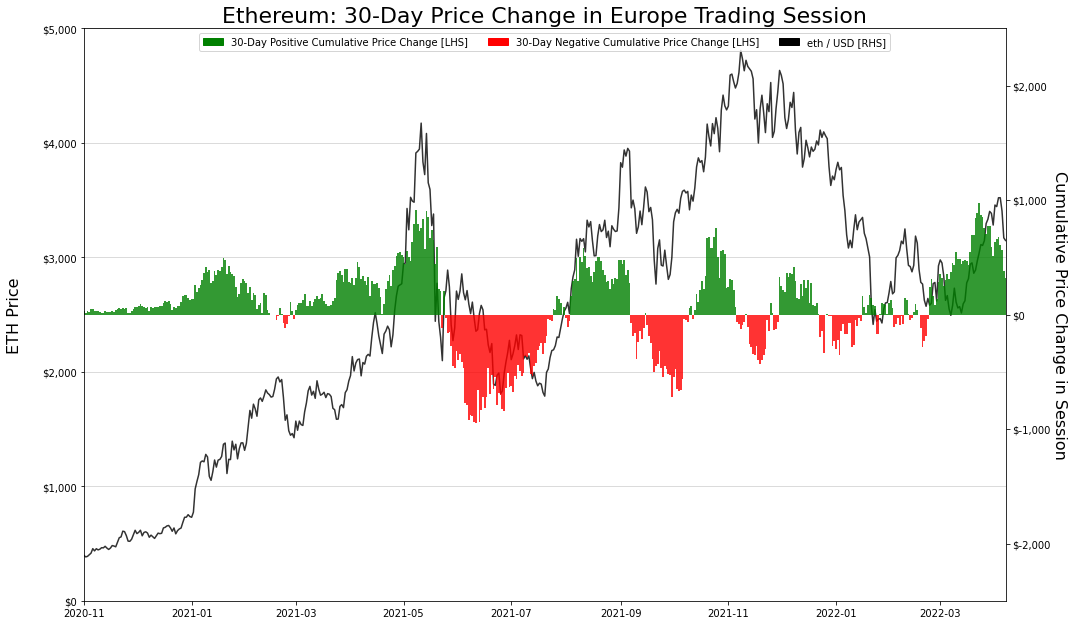

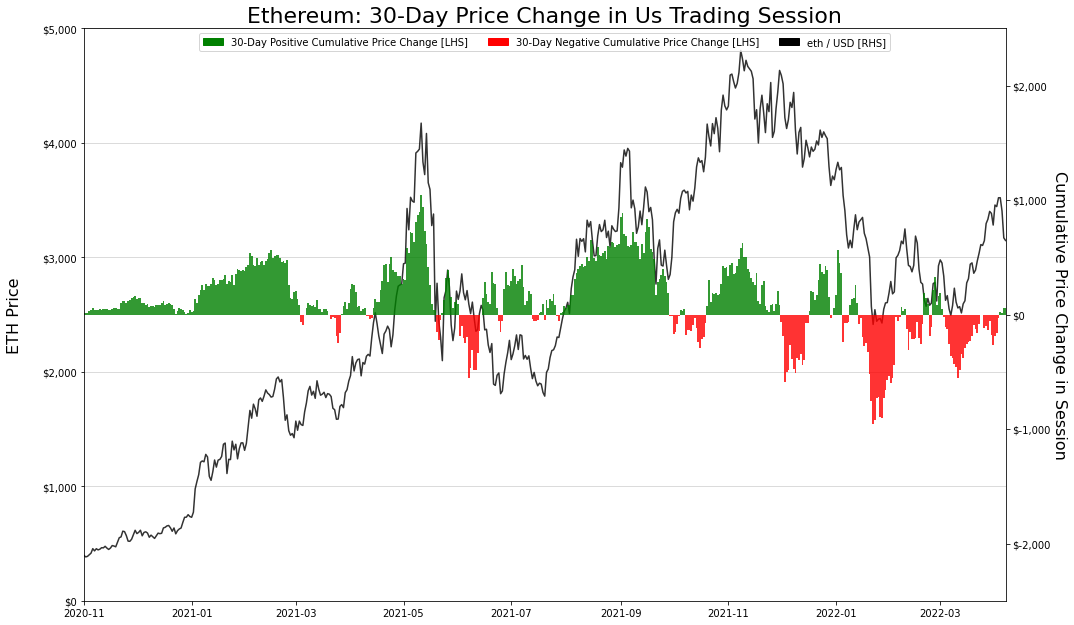

In [212]:
session = ['asia', 'europe', 'us']

for s in session:
    # create a figure with our default parameters
    fig, ax1 = set_plt_defaults()

    # dynamic title dependant on window size
    plt.title(f'Ethereum: {ws}-Day Price Change in {s.capitalize()} Trading Session', size=22)
    
    ax1.plot(tmp_df['date'], 
             tmp_df['close'], 
             color='k', 
             alpha=0.8)
    
    ax1.set_ylabel('ETH Price', fontsize=16, labelpad=20)

    ax1.set_ylim([0, 5000])
    ax1.set_yticklabels(['${:,.0f}'.format(x) for x in ax1.get_yticks()])
    
    # create copy of x-axis so we can plot another data segment
    ax2 = ax1.twinx()

    # custom labels
    green_patch = mpatches.Patch(color='g', label=f'{ws}-Day Positive Cumulative Price Change [LHS]')
    red_patch = mpatches.Patch(color='r', label=f'{ws}-Day Negative Cumulative Price Change [LHS]')
    black_patch = mpatches.Patch(color='k', label='eth / USD [RHS]')

    # add legend
    ax1.legend(handles=[green_patch, red_patch, black_patch], loc='upper center', ncol=3)


    # bar plot, red for negative prices and green for positive
    ax2.bar(tmp_df['date'], 
            tmp_df[f'{s}-change'].rolling(ws).sum(), 
            width=1.0, 
            alpha=0.8,
            color=['r' if (x < 0) else 'g' for x in tmp_df[f'{s}-change'].rolling(ws).sum()])

    #set y label 
    ax2.set_ylabel('Cumulative Price Change in Session', rotation=270, fontsize=16, labelpad=16)
    
    # set axis boundary limits
    ax2.set_xlim(tmp_df['date'][ws], tmp_df['date'][-1])
    ax2.set_ylim([-2500, 2500])

    # set tick labels
    ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])


    #save figure
    plt.savefig(f'./img/eth_price-change-{s}.png', transparent=False, facecolor='white')

    plt.show()